#  Forecasting taxi orders

The taxi company has collected historical data on taxi bookings at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour.

It is necessary to build a model for such a prediction.

Plan:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters.
4. Check the data on the test sample and draw conclusions.

Data Description:
  - `num_orders` number of orders

<h1>Content<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Exploratory-data-analysis" data-toc-modified-id="Exploratory-data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory data analysis</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model training</a></span><ul class="toc-item"><li><span><a href="#Creating-features" data-toc-modified-id="Creating-features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Creating features</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>ElasticNet</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#<Model-testing" data-toc-modified-id="Model-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model testing</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span>

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat
import lightgbm as lgb
from prophet import Prophet
!pip install catboost --quiet
import catboost as cb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 76.6 MB 118 kB/s 


In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col = ['datetime'], parse_dates = ['datetime'])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


We read the data, converted the date format to datetime, and set the date as the index.  
Sort the table in chronological order.

In [4]:
df = df.sort_index()
df.index.is_monotonic

True

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data are presented in the range from 03/01/2018 to 08/31/2018 with a step of 10 minutes.  
There are no gaps, the data type is correct.  
Since it is necessary to predict the number of taxi orders for the next hour, we will perform reseperation one hour at a time.

In [6]:
df = df.resample('1H').sum()

The data is prepared for analysis and model building (changed the date format, added it to the index, sorted, resampled by one hour).

## Exploratory data analysis

Let's look at the number of orders by day and add a moving average (by month).

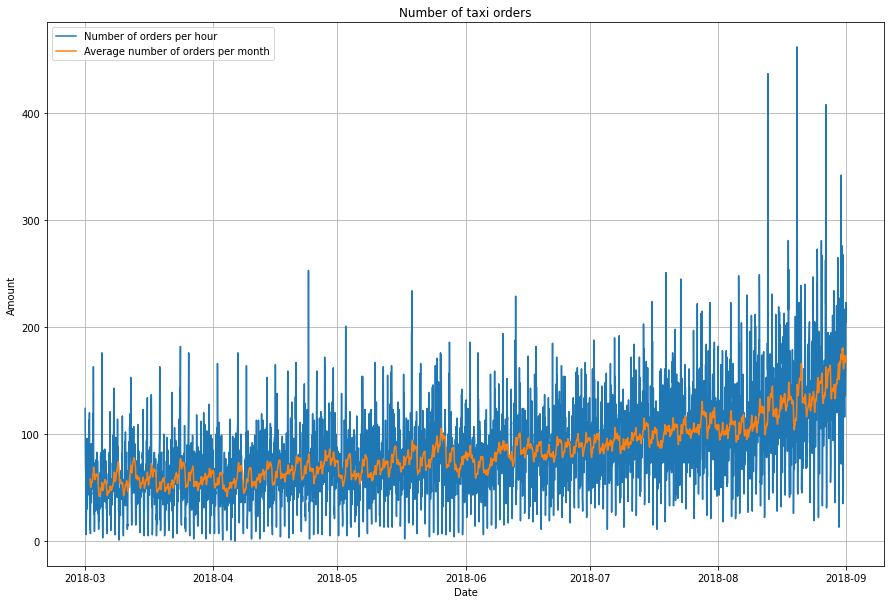

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(df, label="Number of orders per hour")
plt.plot(df.rolling(30).mean(), label="Average number of orders per month")
plt.legend()
plt.title('Number of taxi orders')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)

The number of orders is growing.  
Check for trend and seasonality.

In [8]:
decomposed = seasonal_decompose(df)

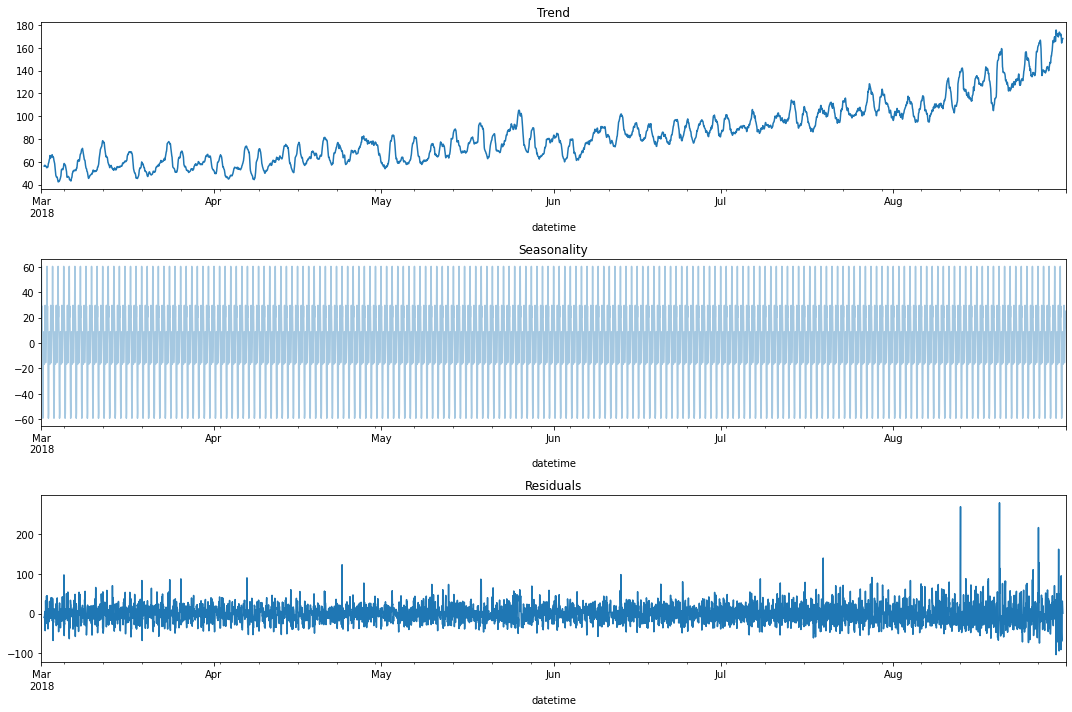

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), alpha=0.4)
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

There is a trend towards an increase in the number of orders from March to September 2018.  
Let's take a closer look at seasonality.

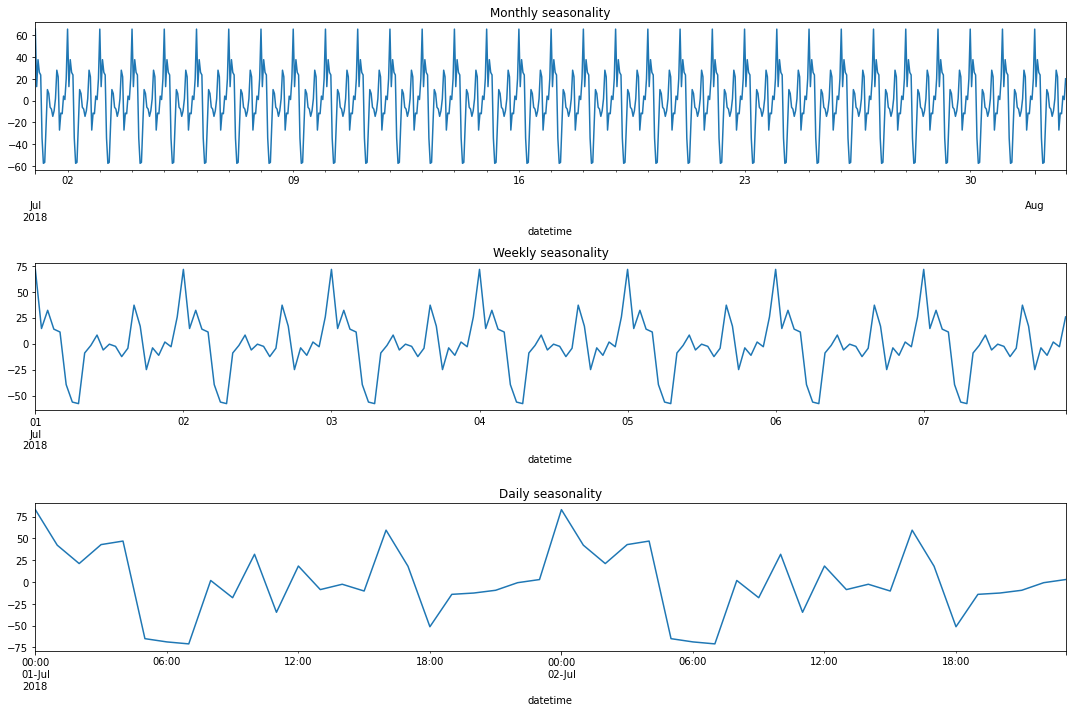

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
seasonal_decompose(df['2018-07-01':'2018-08-01']).seasonal.plot(ax=plt.gca())
plt.title('Monthly seasonality')

plt.subplot(312)
seasonal_decompose(df['2018-07-01':'2018-07-07']).seasonal.plot(ax=plt.gca())
plt.title('Weekly seasonality')

plt.subplot(313)
seasonal_decompose(df['2018-07-01':'2018-07-02']).seasonal.plot(ax=plt.gca())
plt.title('Daily seasonality')

plt.tight_layout()

There is daily seasonality in the data.  
We can notice that the number of taxi orders peaks at night, around 0 o'clock, while in the period from 5 to 7 am the lowest value of taxi orders. This is due to the fact that at night public transport from the airport does not run or runs very rarely (depending on the city), which contributes to the growth of taxi orders.

## Model training

### Creating features

Let's write a function to create features (day of the week, hour, remaining values and moving average).

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Applying a function.

In [12]:
make_features(df, 24, 24).head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Divide the data into training and test samples in a ratio of 9 to 1.

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [14]:
train.shape

(3974, 28)

In [15]:
test.shape

(442, 28)

Remove gaps in the test sample.

In [17]:
train = train.dropna()

Let's highlight the features and the target.

In [18]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

Let's create a function to add the results of the models.

In [19]:
results = {'name': [], 'best_params':[], 'RMSE':[]}

def add_model_result(results, name, best_params, rmse):
    results['name'].append(name)
    results['best_params'].append(best_params)
    results['RMSE'].append(rmse)

To assess the quality of the model, we will use TimeSeriesSplit, since for the time series it is necessary to take into account chronologies during cross-validation.

Selection of hyperparameters for models.

### LinearRegression

In [20]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [21]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False]}
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f0be9e8f050>,
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error')

In [22]:
print('LinearRegression', (abs(grid.best_score_))**0.5, grid.best_params_)

LinearRegression 26.865382062299556 {'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [23]:
add_model_result(results, 'LinearRegression', grid.best_params_, (abs(grid.best_score_))**0.5)

### Lasso

In [24]:
model = Lasso()
parameters = {'alpha':[0.0005,0.0006,0.06,0.5,0.0001,0.01,1,2,3,4,4.4,4]}
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f0be9e8fad0>,
             estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0006, 0.06, 0.5, 0.0001, 0.01, 1,
                                   2, 3, 4, 4.4, 4]},
             scoring='neg_mean_squared_error')

In [25]:
print('Lasso', (abs(grid.best_score_))**0.5, grid.best_params_)

Lasso 26.85465587640938 {'alpha': 4}


In [26]:
add_model_result(results, 'Lasso', grid.best_params_, (abs(grid.best_score_))**0.5)

### ElasticNet

In [27]:
model = ElasticNet()
parameters = {'max_iter': [1, 5, 10], 
              'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'l1_ratio': np.arange(0.0, 1.0, 0.1)}
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid_en = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=tscv)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f0be9e8fed0>,
             estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]},
             scoring='neg_mean_squared_error')

In [28]:
print('ElasticNet', (abs(grid_en.best_score_))**0.5, grid_en.best_params_)

ElasticNet 26.851975739889248 {'alpha': 10, 'l1_ratio': 0.4, 'max_iter': 10}


In [29]:
add_model_result(results, 'ElasticNet', grid_en.best_params_, (abs(grid_en.best_score_))**0.5)

### CatBoost

In [30]:
%%time
model = CatBoostRegressor(silent=True)

parameters = {'depth' : sp_randint(1, 10),
              'learning_rate' : [0.01, 0.02, 0.03, 0.5, 0.6, 0.7],
              'iterations' : sp_randint(10, 400)
             }
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid_cat = RandomizedSearchCV(model,parameters, scoring='neg_mean_squared_error', cv=tscv)
grid_cat.fit(X_train, y_train)

CPU times: user 2min 57s, sys: 8.09 s, total: 3min 5s
Wall time: 1min 57s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f0be9e6ff50>,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f0be9e64590>,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0be9ea0c10>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0be9ea0f10>,
                                        'learning_rate': [0.01, 0.02, 0.03, 0.5,
                                                          0.6, 0.7]},
                   scoring='neg_mean_squared_error')

In [31]:
print('CatBoost', (abs(grid_cat.best_score_))**0.5, grid_cat.best_params_)

CatBoost 24.63512972381135 {'depth': 7, 'iterations': 339, 'learning_rate': 0.02}


In [32]:
add_model_result(results, 'CatBoost', grid_cat.best_params_, (abs(grid_cat.best_score_))**0.5)

### LightGBM 

In [33]:
%%time
model = lgb.LGBMRegressor()
parameters = {'num_leaves' : [20,40,60,80,100],
              'max_depth' : sp_randint(1, 10),
              'reg_alpha':[0,0.01,0.03]}

tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid_lgb = RandomizedSearchCV(model,parameters, scoring='neg_mean_squared_error', cv=tscv)
grid_lgb.fit(X_train, y_train)

CPU times: user 22.1 s, sys: 534 ms, total: 22.7 s
Wall time: 11.8 s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f0be9e6fb50>,
                   estimator=LGBMRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0be9d64410>,
                                        'num_leaves': [20, 40, 60, 80, 100],
                                        'reg_alpha': [0, 0.01, 0.03]},
                   scoring='neg_mean_squared_error')

In [34]:
print('LightGBM', (abs(grid_lgb.best_score_))**0.5, grid_lgb.best_params_)

LightGBM 24.408485521130892 {'max_depth': 4, 'num_leaves': 40, 'reg_alpha': 0}


In [35]:
add_model_result(results, 'LightGBM', grid_lgb.best_params_, (abs(grid_lgb.best_score_))**0.5)

### Prophet

For this model, we will prepare the data and select a validation set.

In [36]:
train_prophet = train['num_orders'].reset_index().copy()
train_prophet.columns = ['ds', 'y']
train_prophet, valid_prophet = train_test_split(train_prophet, shuffle=False, test_size=0.2)

Train the model and calculate RMSE.

In [37]:
model = Prophet()
model.fit(train_prophet)
forecast = model.predict(pd.DataFrame(valid_prophet['ds']))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphov5_c__/_c0y5434.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphov5_c__/0gep02co.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7833', 'data', 'file=/tmp/tmphov5_c__/_c0y5434.json', 'init=/tmp/tmphov5_c__/0gep02co.json', 'output', 'file=/tmp/tmphov5_c__/prophet_model_ii8ayff/prophet_model-20221109095202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:52:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [38]:
(mean_squared_error(valid_prophet['y'], forecast['yhat']))**0.5

32.23223390896504

In [39]:
add_model_result(results, 'Prophet', '', (mean_squared_error(valid_prophet['y'], forecast['yhat']))**0.5)

### Results

In [40]:
pd.DataFrame(results).sort_values('RMSE')


,name,best_params,RMSE
4,LightGBM,"{'max_depth': 4, 'num_leaves': 40, 'reg_alpha'...",24.408486
3,CatBoost,"{'depth': 7, 'iterations': 339, 'learning_rate...",24.635130
2,ElasticNet,"{'alpha': 10, 'l1_ratio': 0.4, 'max_iter': 10}",26.851976
1,Lasso,{'alpha': 4},26.854656
0,LinearRegression,"{'copy_X': True, 'fit_intercept': False, 'norm...",26.865382
5,Prophet,,32.232234


The best model is LightGBM with parameters: `max_depth' = 4, 'num_leaves' = 40, 'reg_alpha' = 0`, showing RMSE = 24.4.

## Model testing

In [42]:
lgbm = grid_lgb.best_estimator_
lgbm.fit(X_train, y_train)
predictions = lgbm.predict(X_test)
mean_squared_error(y_test, predictions)**0.5

42.02772844003646

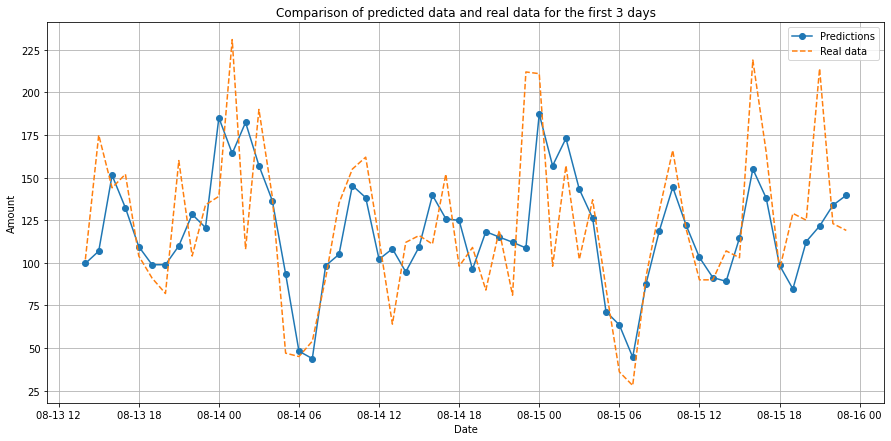

In [43]:
plt.figure(figsize=(15, 7))
plt.plot(pd.Series(predictions, index=y_test.index)['2018-08-13':'2018-08-15'], label="Predictions", marker='o')
plt.plot(y_test['2018-08-13':'2018-08-15'], label="Real data", linestyle='dashed')
plt.legend()
plt.title('Comparison of predicted data and real data for the first 3 days')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.grid(True)

## Conclusion

We have analyzed a time series containing information about the number of taxi orders. An upward trend was revealed for an increase in the number of orders for the given period (from 03/01/2018 to 08/31/2018) and daily seasonality.  
Prepared data for building a model, added features: day of the week, hour, remaining values ​​and moving average.  
Several machine learning models were tested, the best one was chosen, which was LightGBM with hyperparameters: `max_depth' = 4, 'num_leaves' = 40, 'reg_alpha' = 0`, and tested on a test sample, showing an RMSE value of 42.03.

The goal of the project (to predict the number of taxi orders for the next hour) has been achieved.